<h1 align="center">Introduction to Machine Learning - 25737-2</h1>
<h4 align="center">Dr. R. Amiri</h4>
<h4 align="center">Sharif University of Technology, Spring 2024</h4>


<link rel="preconnect" href="https://fonts.googleapis.com">
<link rel="preconnect" href="https://fonts.gstatic.com" crossorigin>
<link href="https://fonts.googleapis.com/css2?family=Titillium+Web:ital,wght@0,200;0,300;0,400;0,600;0,700;0,900;1,200;1,300;1,400;1,600;1,700&display=swap" rel="stylesheet">
<div class="box" style="padding: 10px; margin: 10px 0; background-color: gray; color: white; border-radius: 5px; font-size: 15px;">
  <table style="padding: 10px; margin: auto auto; background-color: gray;  border-radius: 5px; font-size: 15px;">
      <tr>
          <th colspan='2'><h1 style="text-align: center">
Machine Learning </br>
</h1>
<h2 style="text-align: center">
Course Assignment Two </br>
</h2>
</th>
<tr>
    <tr>
      <th colspan="2">Personal Info</th>
    </tr>
    <tr>
      <td>First Name:</td>
      <td>Ali</td>
    </tr>
    <tr>
      <td>Last Name:</td>
      <td>Nikkhah</td>
    </tr>
    <tr>
      <td>Student Number:</td>
      <td>99102445</td>
    </tr>
    <tr>
      <td>Github:</td>
      <td><a href="https://github.com/AliNikkhah2001/MachineLearning02" target="_blank">https://github.com/AliNikkhah2001/MachineLearning02</a></td>
    </tr>
  </table>
</div>



## Question 1) Convolutional Neural Networks ``(50 pt.)``

In this question, you'll be coding up a convolutional neural network from scratch to classify images using PyTorch.  

### Instructions
- Install PyTorch following the instructions [here](https://pytorch.org/).
- Install the [`torchinfo` package](https://github.com/TylerYep/torchinfo) to visualize the network architecture and the number of parameters. The maximum number of parameters you are allowed to use for your network is **100,000**. 
- You are required to complete the functions defined in the code blocks following each question. Fill out sections of the code marked `"YOUR CODE HERE"`.
- You're free to add any number of methods within each class.
- You may also add any number of additional code blocks that you deem necessary.

### Data Preparation
In this assignment, we will use the Fashion-MNIST dataset. Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes.  

#### Data

Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255.  

#### Labels

Each training and test example is assigned to one of the following labels:

| Label | Description |
|-------|-------------|
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Fashion-MNIST is included in the `torchvision` library.

In [ ]:
# Import required packages
from torchvision.datasets import FashionMNIST
from torchvision.transforms import Compose, ToTensor, Normalize
import matplotlib.pyplot as plt

In [2]:
# Transform to normalize the data and convert to a tensor
transform = Compose([ToTensor(), Normalize((0.5,), (0.5,))])

# Download the data
dataset = FashionMNIST('MNIST_data/', download = True, train = True, transform = transform)

### Data Exploration
Let's take a look at the classes in our dataset.

In [3]:
print(dataset.classes)

['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


Now, visualize an instance from each class.

In [4]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt


In [5]:
loader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)


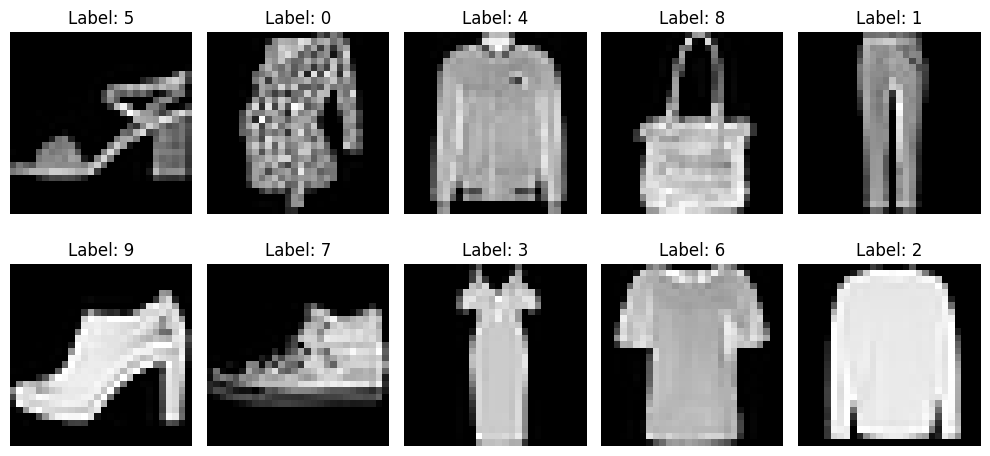

In [6]:
class_images = {}
fig, axes = plt.subplots(2, 5, figsize=(10, 5))  
axes = axes.flatten()

# Retrieve an example of each class
for images, labels in loader:
    label = labels.item()
    if label not in class_images:
        class_images[label] = images[0]  # Store the first image tensor
    if len(class_images) == 10:
        break

# Normalize back the images for visualization
for i, (label, image) in enumerate(class_images.items()):
    image = image.squeeze()  # Remove unnecessary dimensions
    image = image * 0.5 + 0.5  # Undo normalization for visualization
    axes[i].imshow(image.numpy(), cmap='gray')
    axes[i].set_title(f'Label: {label}')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


### Creating Training and Validation Datasets

The `split_indices` function takes in the size of the entire dataset, `n`, the fraction of data to be used as validation set, `val_frac`, and the random seed and returns the indices of the data points to be added to the validation dataset. 

In [7]:
import numpy as np

def split_indices(n, val_frac, seed):
    # Determine the size of the validation set
    n_val = int(val_frac * n)
    np.random.seed(seed)
    # Create random permutation between 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indices for validation set
    return idxs[n_val:], idxs[:n_val]



In [8]:
# Parameters for splitting data
val_frac = 0.1  # Use 10% of the data for validation
rand_seed = 42  # Random seed for reproducibility

train_indices, val_indices = split_indices(len(dataset), val_frac, rand_seed)
print("Number of samples in training set: {}".format(len(train_indices)))
print("Number of samples in validation set: {}".format(len(val_indices)))


Number of samples in training set: 54000
Number of samples in validation set: 6000


Next, we make use of the built-in dataloaders in PyTorch to create iterables of our our training and validation sets. This helps in avoiding fitting the whole dataset into memory and only loads a batch of the data that we can decide. 

In [9]:
# Import required packages
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [10]:
from torch.utils.data import DataLoader, SubsetRandomSampler

# Set the batch size
batch_size = 64  # Common batch size for training

# Training sampler and data loader
train_sampler = SubsetRandomSampler(train_indices)
train_dl = DataLoader(dataset, batch_size, sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indices)
val_dl = DataLoader(dataset, batch_size, sampler=val_sampler)


Plot images in a sample batch of data.

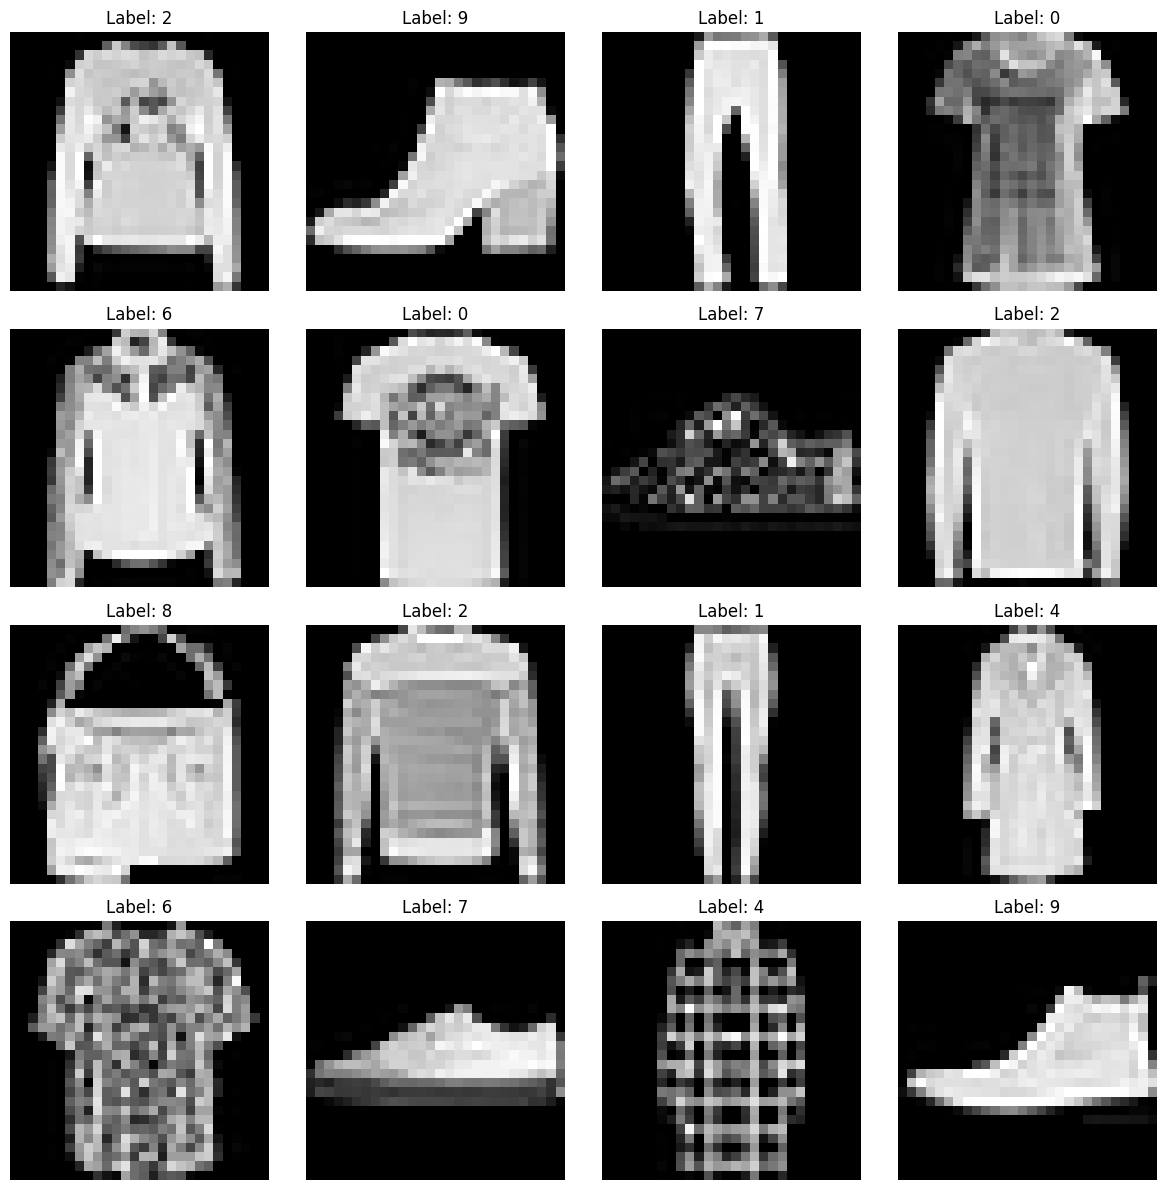

In [11]:
def show_batch(dl):
    """Display images from a DataLoader batch."""
    for images, labels in dl:
        plt.figure(figsize=(12, 12))
        for i in range(16):  # Show 16 images from the batch
            ax = plt.subplot(4, 4, i + 1)
            img = images[i] * 0.5 + 0.5  # Unnormalize the image
            plt.imshow(img.squeeze(), cmap='gray')
            plt.title(f'Label: {labels[i]}')
            plt.axis('off')
        plt.tight_layout()
        break  # Only show the first batch

# Visualize a batch of the training data
show_batch(train_dl)


### Building the Model
Create your model by defining the network architecture in the `ImageClassifierNet` class.<br>
**NOTE:** The number of parameters in your network must be $\leq$ 100,000.

In [14]:
%%capture
!pip install torchinfo


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary


In [16]:
class ImageClassifierNet(nn.Module):
    def __init__(self):
        super(ImageClassifierNet, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # Keep at 16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1) # Keep at 32
        self.pool = nn.MaxPool2d(2, 2)  # Pooling layer
        
        # Fully connected layers
        # Further reduce the fully connected layer sizes
        self.fc1 = nn.Linear(32 * 7 * 7, 50)  # Reduced to 50 from 64
        self.fc2 = nn.Linear(50, 25)  # Reduced to 25 from 32
        self.fc3 = nn.Linear(25, 10)  # Output layer for 10 classes

    def forward(self, x):
        # Apply convolutions, activation function, and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        # Flatten the tensor for the fully connected layers
        x = x.view(-1, 32 * 7 * 7)
        
        # Apply fully connected layers with ReLU activations for hidden layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation needed in the output layer
        return x


The following code block prints your network architecture. It also shows the total number of parameters in your network (see `Total params`).  

**NOTE: The total number of parameters in your model should be <= 100,000.**

In [17]:
model = ImageClassifierNet()
summary(model, input_size=(batch_size, 1, 28, 28))


Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [64, 10]                  --
├─Conv2d: 1-1                            [64, 16, 28, 28]          160
├─MaxPool2d: 1-2                         [64, 16, 14, 14]          --
├─Conv2d: 1-3                            [64, 32, 14, 14]          4,640
├─MaxPool2d: 1-4                         [64, 32, 7, 7]            --
├─Linear: 1-5                            [64, 50]                  78,450
├─Linear: 1-6                            [64, 25]                  1,275
├─Linear: 1-7                            [64, 10]                  260
Total params: 84,785
Trainable params: 84,785
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 71.35
Input size (MB): 0.20
Forward/backward pass size (MB): 9.68
Params size (MB): 0.34
Estimated Total Size (MB): 10.22

### Train the model
Complete the `train_model` function to train your model on a dataset. Tune your network architecture and hyperparameters on the validation set.

In [18]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


In [19]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):

    model.train()
    for epoch in range(n_epochs):
        total_train_loss = 0
        total_train = 0
        correct_train = 0

        # Training loop
        for images, labels in train_dl:
            images, labels = images.to(device), labels.to(device)
            opt_fn.zero_grad()  # Zero the gradients
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt_fn.step()

            total_train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        # Record training results
        avg_train_loss = total_train_loss / len(train_dl)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation loop only if val_dl is not empty
        if val_dl:
            model.eval()
            total_val_loss = 0
            total_val = 0
            correct_val = 0
            with torch.no_grad():
                for images, labels in val_dl:
                    images, labels = images.to(device), labels.to(device)
                    outputs = model(images)
                    val_loss = loss_fn(outputs, labels)
                    total_val_loss += val_loss.item()
                    _, predicted = torch.max(outputs.data, 1)
                    correct_val += (predicted == labels).sum().item()
                    total_val += labels.size(0)

            avg_val_loss = total_val_loss / len(val_dl)
            val_accuracy = correct_val / total_val
            val_losses.append(avg_val_loss)
            val_accuracies.append(val_accuracy)

        # Display results for the epoch
        print(f'Epoch {epoch+1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Train Acc: {train_accuracy:.4f}', end='')
        if val_dl:
            print(f', Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}')
        else:
            print()

    return model, train_losses, val_losses, train_accuracies, val_accuracies


In [20]:
num_epochs = 10  # Number of training epochs
loss_fn = torch.nn.CrossEntropyLoss()  # Loss function for classification
opt_fn = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer
lr = 0.001  # Learning rate
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr
)



Epoch 1/10, Train Loss: 0.5787, Train Acc: 0.7919, Val Loss: 0.3905, Val Acc: 0.8535
Epoch 2/10, Train Loss: 0.3624, Train Acc: 0.8691, Val Loss: 0.3449, Val Acc: 0.8730
Epoch 3/10, Train Loss: 0.3131, Train Acc: 0.8863, Val Loss: 0.3016, Val Acc: 0.8887
Epoch 4/10, Train Loss: 0.2816, Train Acc: 0.8972, Val Loss: 0.3009, Val Acc: 0.8885
Epoch 5/10, Train Loss: 0.2569, Train Acc: 0.9057, Val Loss: 0.2766, Val Acc: 0.9000
Epoch 6/10, Train Loss: 0.2385, Train Acc: 0.9116, Val Loss: 0.2566, Val Acc: 0.9067
Epoch 7/10, Train Loss: 0.2246, Train Acc: 0.9160, Val Loss: 0.2538, Val Acc: 0.9060
Epoch 8/10, Train Loss: 0.2076, Train Acc: 0.9234, Val Loss: 0.2478, Val Acc: 0.9110
Epoch 9/10, Train Loss: 0.1967, Train Acc: 0.9269, Val Loss: 0.2481, Val Acc: 0.9082
Epoch 10/10, Train Loss: 0.1829, Train Acc: 0.9324, Val Loss: 0.2358, Val Acc: 0.9108


### Plot loss and accuracy

In [29]:
import matplotlib.pyplot as plt

def plot_accuracy(train_accuracies, val_accuracies=None):
    """Plot training and optionally validation accuracies."""
    plt.figure(figsize=(8, 5))
    plt.plot(train_accuracies, "-x", label="Training")
    if val_accuracies is not None:
        plt.plot(val_accuracies, "-o", label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Accuracy vs. Number of Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


In [30]:
def plot_losses(train_losses, val_losses=None):
    """Plot training and optionally validation losses."""
    plt.figure(figsize=(8, 5))
    plt.plot(train_losses, "-x", label="Training")
    if val_losses is not None:
        plt.plot(val_losses, "-o", label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss vs. Number of Epochs")
    plt.legend()
    plt.grid(True)
    plt.show()


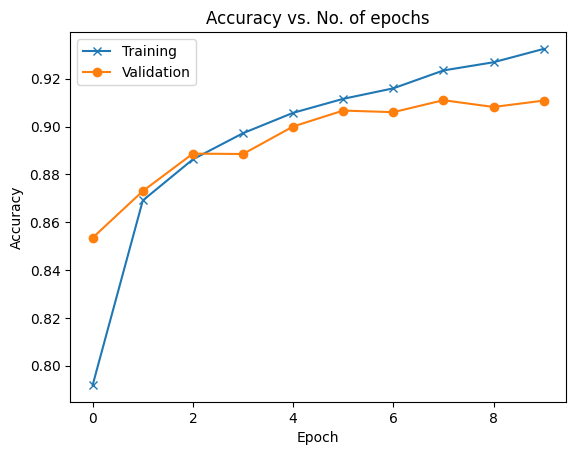

In [22]:
plot_accuracy(train_accuracies, val_accuracies)


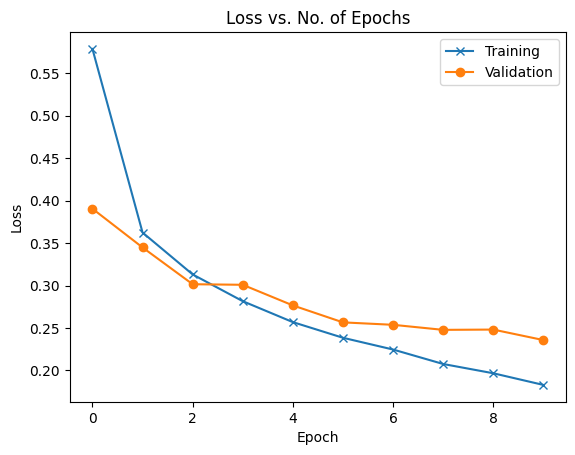

In [23]:
plot_losses(train_losses, val_losses)

### Train a model on the entire dataset

In [27]:
from torch.utils.data import DataLoader
train_losses = []

train_accuracies = []


model = ImageClassifierNet()
summary(model, input_size=(batch_size, 1, 28, 28))
num_epochs = 10  # Number of training epochs
loss_fn = torch.nn.CrossEntropyLoss()  # Loss function for classification
opt_fn = torch.optim.Adam(model.parameters(), lr=0.001)  # Optimizer
lr = 0.001  # Learning rate

# Create DataLoader for the entire dataset
dl = DataLoader(dataset, batch_size, shuffle=True) 



model, train_losses, _, train_accuracies, _= train_model(num_epochs, model, dl, [], loss_fn, opt_fn, lr)
print("Training complete!")


Epoch 1/10, Train Loss: 0.5721, Train Acc: 0.7904
Epoch 2/10, Train Loss: 0.3583, Train Acc: 0.8698
Epoch 3/10, Train Loss: 0.3070, Train Acc: 0.8880
Epoch 4/10, Train Loss: 0.2736, Train Acc: 0.9002
Epoch 5/10, Train Loss: 0.2498, Train Acc: 0.9074
Epoch 6/10, Train Loss: 0.2297, Train Acc: 0.9156
Epoch 7/10, Train Loss: 0.2130, Train Acc: 0.9213
Epoch 8/10, Train Loss: 0.1975, Train Acc: 0.9268
Epoch 9/10, Train Loss: 0.1867, Train Acc: 0.9298
Epoch 10/10, Train Loss: 0.1751, Train Acc: 0.9341
Training complete!


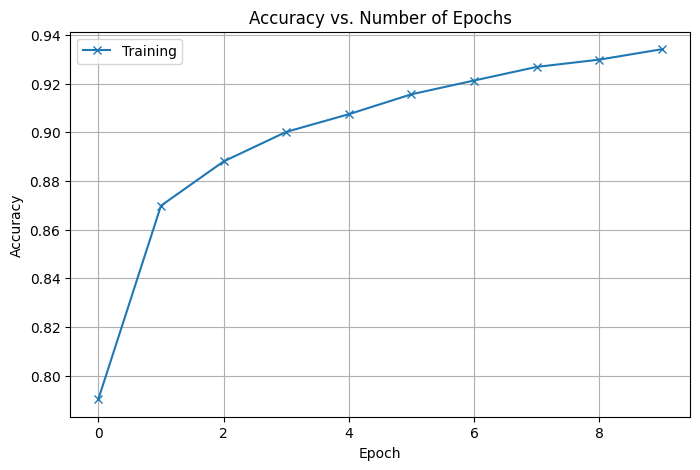

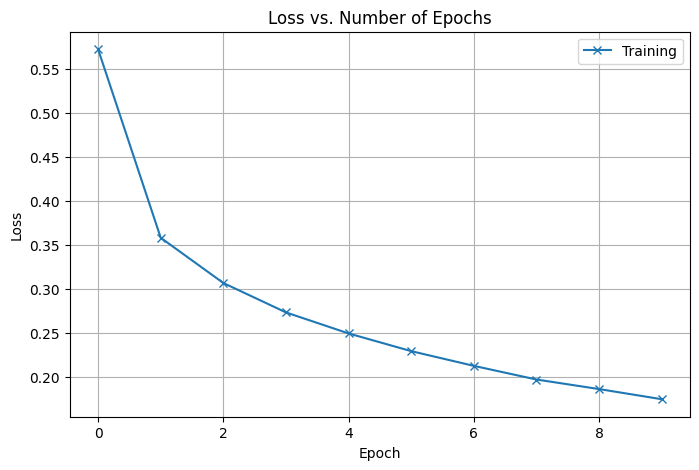

In [31]:
plot_accuracy(train_accuracies)
plot_losses(train_losses)

### Check Predictions
Now, you should evaluate your model on dataset. Specifically, you should calculate the class probabilities for each image, and then visualize these probabilities along with the image itself. Please include a function `view_prediction` in your code that takes an image, its label, the calculated probabilities, and the list of class names as input, and plots the image along with the probabilities.

In [32]:
import matplotlib.pyplot as plt

def view_prediction(image, label, probabilities, class_names):
    """
    Display the image and the probabilities for each class.
    
    Args:
        image (torch.Tensor): The image data.
        label (int): The true label of the image.
        probabilities (torch.Tensor): Probabilities for each class.
        class_names (list): List of class names.
    """
    probabilities = probabilities.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(image.resize_(1, 28, 28).numpy().squeeze(), cmap='gray')
    ax1.axis('off')
    ax1.set_title(class_names[label])

    ax2.barh(np.arange(10), probabilities)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(class_names, size='small');
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()

# Load class names for Fashion-MNIST
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


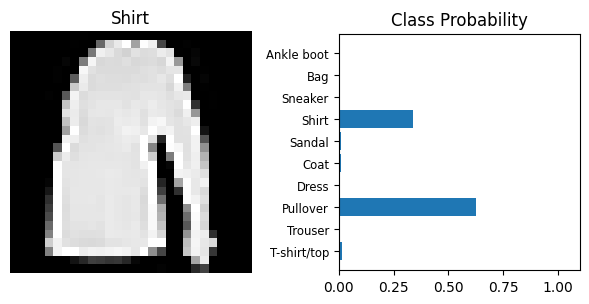

In [43]:
# Switch model to evaluation mode
model.eval()

# Randomly select an image from the dataset
images, labels = next(iter(dl))
images, labels = images.to(device), labels.to(device)
img = images[0].unsqueeze(0)  # Add batch dimension

# Forward pass to get output/logits
with torch.no_grad():
    outputs = model(img)

# Get probabilities from the outputs
probabilities = torch.nn.functional.softmax(outputs, dim=1)

# Visualize the predictions for the selected image
view_prediction(images[0], labels[0].item(), probabilities, class_names)


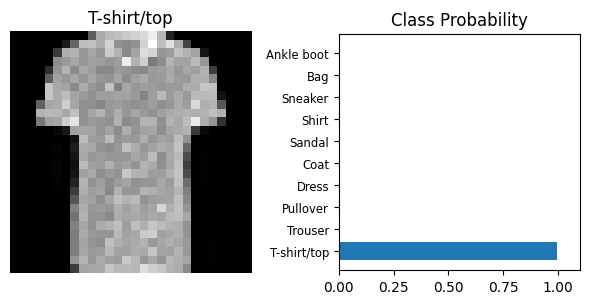

In [44]:
# Switch model to evaluation mode
model.eval()

# Randomly select an image from the dataset
images, labels = next(iter(dl))
images, labels = images.to(device), labels.to(device)
img = images[0].unsqueeze(0)  # Add batch dimension

# Forward pass to get output/logits
with torch.no_grad():
    outputs = model(img)

# Get probabilities from the outputs
probabilities = torch.nn.functional.softmax(outputs, dim=1)

# Visualize the predictions for the selected image
view_prediction(images[0], labels[0].item(), probabilities, class_names)


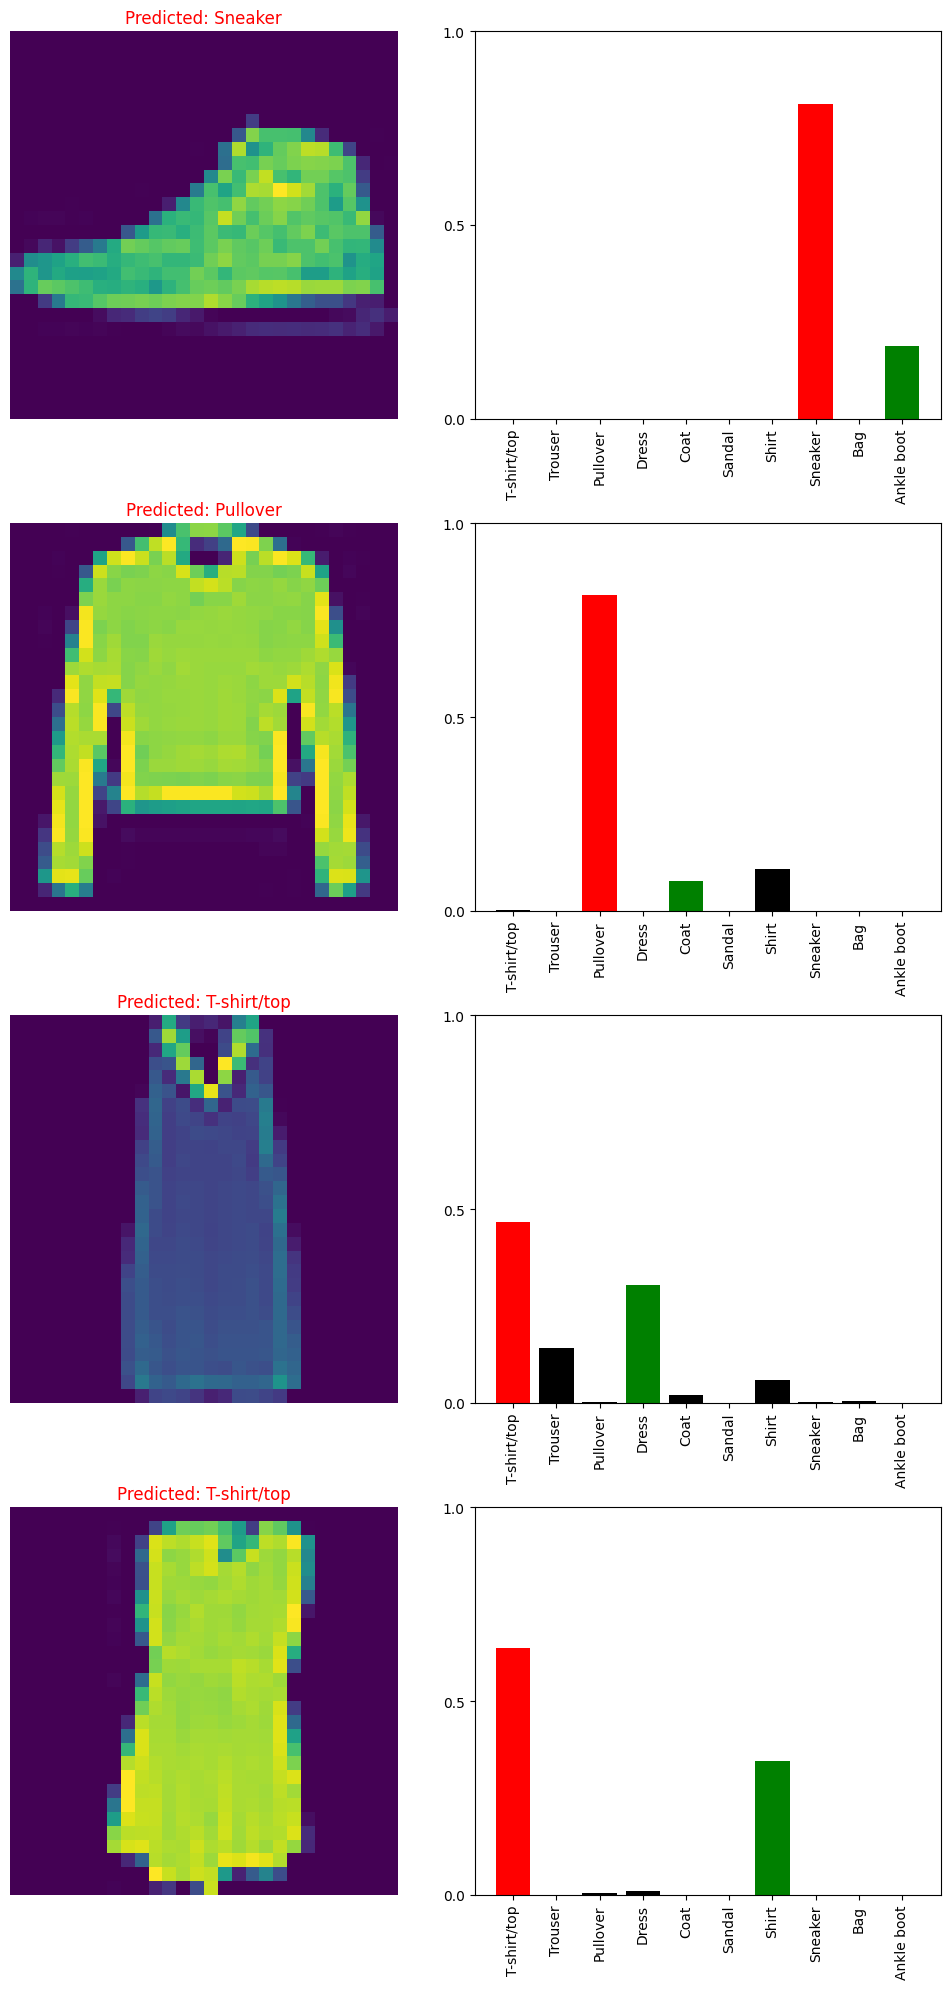

In [48]:
import torch
import matplotlib.pyplot as plt

def visualize_misclassifications(model, dataloader, class_names, device):
    model.eval()  # Set the model to evaluation mode
    fig, axes = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))
    axes = axes.flatten()
    count = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        with torch.no_grad():
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

        misclassified_indices = (predicted != labels).nonzero(as_tuple=True)[0]

        for idx in misclassified_indices:
            if count >= 8:
                plt.tight_layout()
                plt.show()
                return
            img = images[idx].cpu()
            label = labels[idx].item()
            pred = predicted[idx].item()

            axes[count].imshow(img.permute(1, 2, 0))  # Assuming img is normalized, additional handling might be needed
            axes[count].axis('off')
            axes[count].set_title(f'Predicted: {class_names[pred]}', color='red')
            axes[count].set_xlabel(f'Real: {class_names[label]}', color='green')

            # Plot probability bars
            probs = probabilities[idx].cpu().numpy()
            colors = ['black'] * len(probs)
            colors[label] = 'green'
            colors[pred] = 'red'
            axes[count + 1].bar(range(len(probs)), probs, color=colors)
            axes[count + 1].set_xticks(range(len(probs)))
            axes[count + 1].set_xticklabels(class_names, rotation=90, color='black')
            axes[count + 1].set_yticks([0, 0.5, 1])
            axes[count + 1].set_ylim([0, 1])

            count += 2

    plt.tight_layout()
    plt.show()

visualize_misclassifications(model, dl, class_names, device)


### Save the model

In [50]:
torch.save(model, 'model.PTH')

### Calculate accuracy on the test set

In [53]:
test_dataset = FashionMNIST('MNIST_data/', download = True, train = False, transform = transform)
test_dl = DataLoader(test_dataset, batch_size)

Accuracy: 90.23%


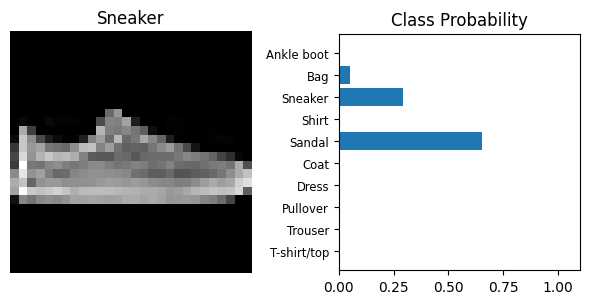

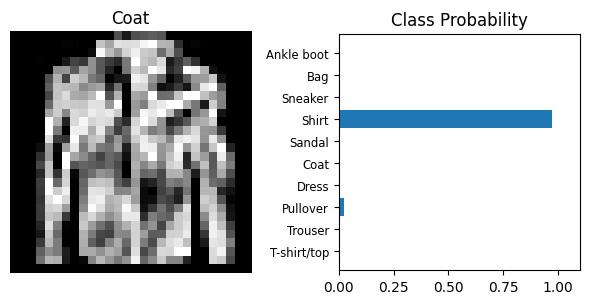

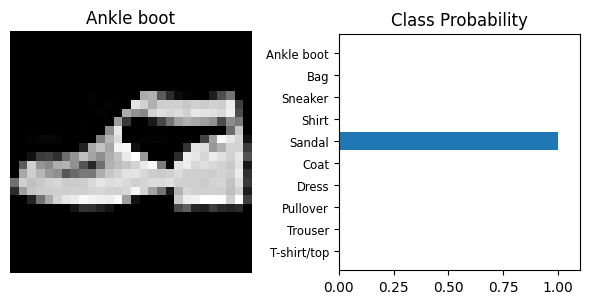

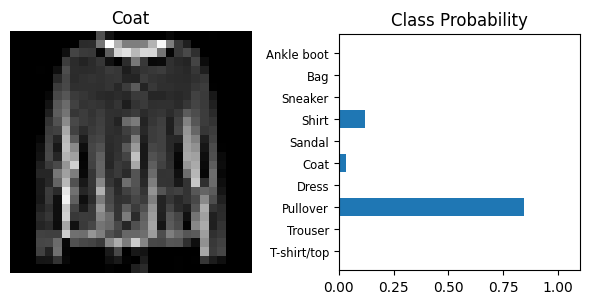

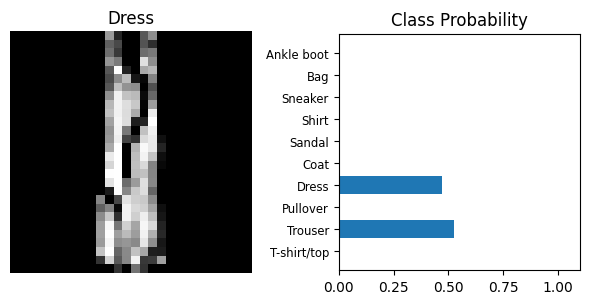

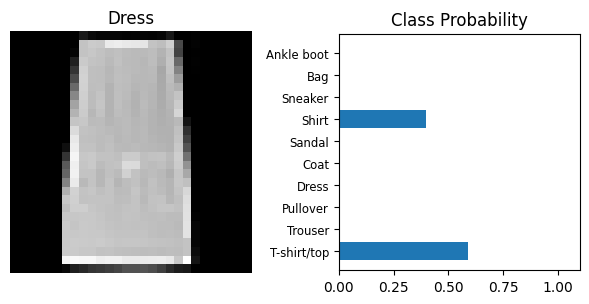

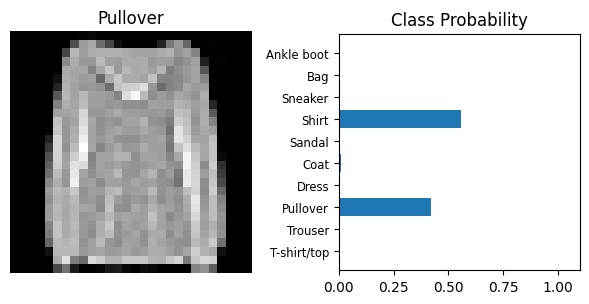

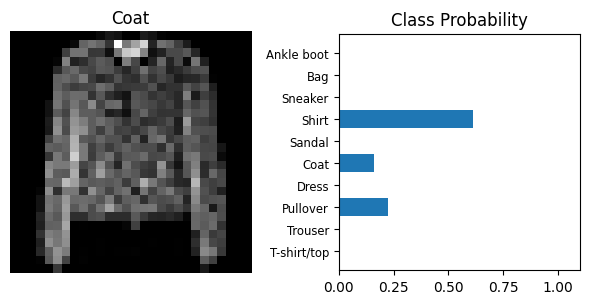

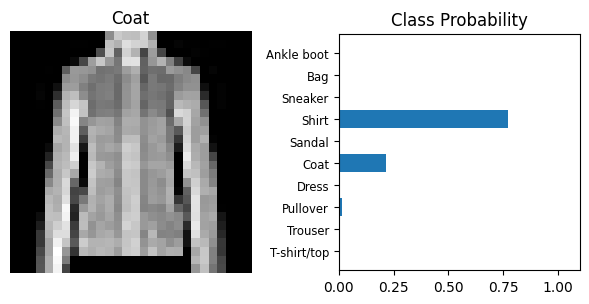

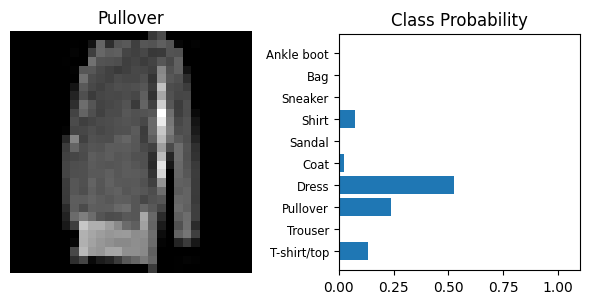

In [55]:
import torch
import matplotlib.pyplot as plt

def evaluate(model, test_dl, device):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0
    wrong_samples = []

    with torch.no_grad():  # No gradients needed
        for images, labels in test_dl:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Save wrong predictions with a limit of 10 samples
            wrong_idxs = (predicted != labels).nonzero(as_tuple=False).squeeze()
            # Ensure wrong_idxs is always iterable
            if wrong_idxs.ndim == 0:
                wrong_idxs = wrong_idxs.unsqueeze(0)  # Make it 1D if it's a scalar

            for idx in wrong_idxs:
                if len(wrong_samples) < 10:
                    wrong_samples.append((images[idx], labels[idx].item(), probabilities[idx]))

    accuracy = 100 * correct / total
    # Optionally plot the wrong predictions
    for image, true_label, probs in wrong_samples:
        view_prediction(image.cpu(), true_label, probs.cpu(), class_names)  # Assuming view_prediction is defined
    return accuracy

# Example usage, assuming 'model' and 'test_dl' are defined and 'device' is set appropriately
accuracy = evaluate(model, test_dl, device)
print(f'Accuracy: {accuracy}%')
